Steane code fault tolerance
====================== 

1. Set up two logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up fault tolerance as per scheme (b) from Goto H. Minimizing resource overheads for fault-tolerant preparation of encoded states of the Steane code. Sci Rep. 2016 Jan 27;6:19578. 

3. Find out if this scheme has a tolerance.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise, 
    count_valid_output_strings,
    string_reverse
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

NOISE = True                             #Test with noise
SHOTS = 10000                            #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0204

SIMULATOR = Aer.get_backend('qasm_simulator')

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = ['0001111',
                       '0110011',
                       '1010101'
                      ]

In [4]:
codewords = ['0000000',
             '1010101',
             '0110011',
             '1100110',
             '0001111',
             '1011010',
             '0111100',
             '1101001'
            ]

In [5]:
if NOISE:
    noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                            TWO_GATE_DEPOLARISING, SINGLE_GATE_ERRORS, TWO_GATE_ERRORS )

In [6]:
qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, ancilla = False, fault_tolerant_b = True)
for i in range(2):
    qubit.set_up_logical_zero(i)
qubit.barrier()
qubit.logical_gate_CX(0, 1)
qubit.barrier()
qubit.logical_measure_data(logical_qubit = 0)
for i in range(3):
    qubit.logical_measure_data(logical_qubit = 1, measure_round = i)

qubit.barrier() 
if NOISE:
    result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
else:
    result = execute(qubit, SIMULATOR, shots=SHOTS).result()
counts = result.get_counts(qubit)
#print(counts)

In [7]:
def process_results_FTb(counts):
    valid_strings = 0
    invalid_strings = 0
    rejected_strings = 0
    processed_strings = 0
    for string, counts in counts.items():
        #need to reverse strings because Qiskit reverses them
        string0 = string_reverse(string.split()[3])
        string1 = string_reverse(string.split()[2])
        string2 = string_reverse(string.split()[1])
        string3 = string_reverse(string.split()[0])
        if string1 == string2:
            if string2 == string3:      
                if string1 in codewords:  #would be reported as valid
                    processed_strings = processed_strings + counts
                    if string0 in codewords:  #would be reported as valid
                        valid_strings = valid_strings + counts
                    else:
                        invalid_strings = invalid_strings + counts
        else:
            rejected_strings = rejected_strings + counts
    error_rate = invalid_strings / processed_strings
    print(f'There are {rejected_strings} strings rejected and {processed_strings} strings submitted for processing')
    print(f'Of these {processed_strings} strings processed there are {valid_strings} valid strings and {invalid_strings} invalid_strings')
    print(f'The error rate is {error_rate:.4f} ')

In [8]:
error_rate = process_results_FTb(counts)

There are 332 strings rejected and 6088 strings submitted for processing
Of these 6088 strings processed there are 5434 valid strings and 654 invalid_strings
The error rate is 0.1074 


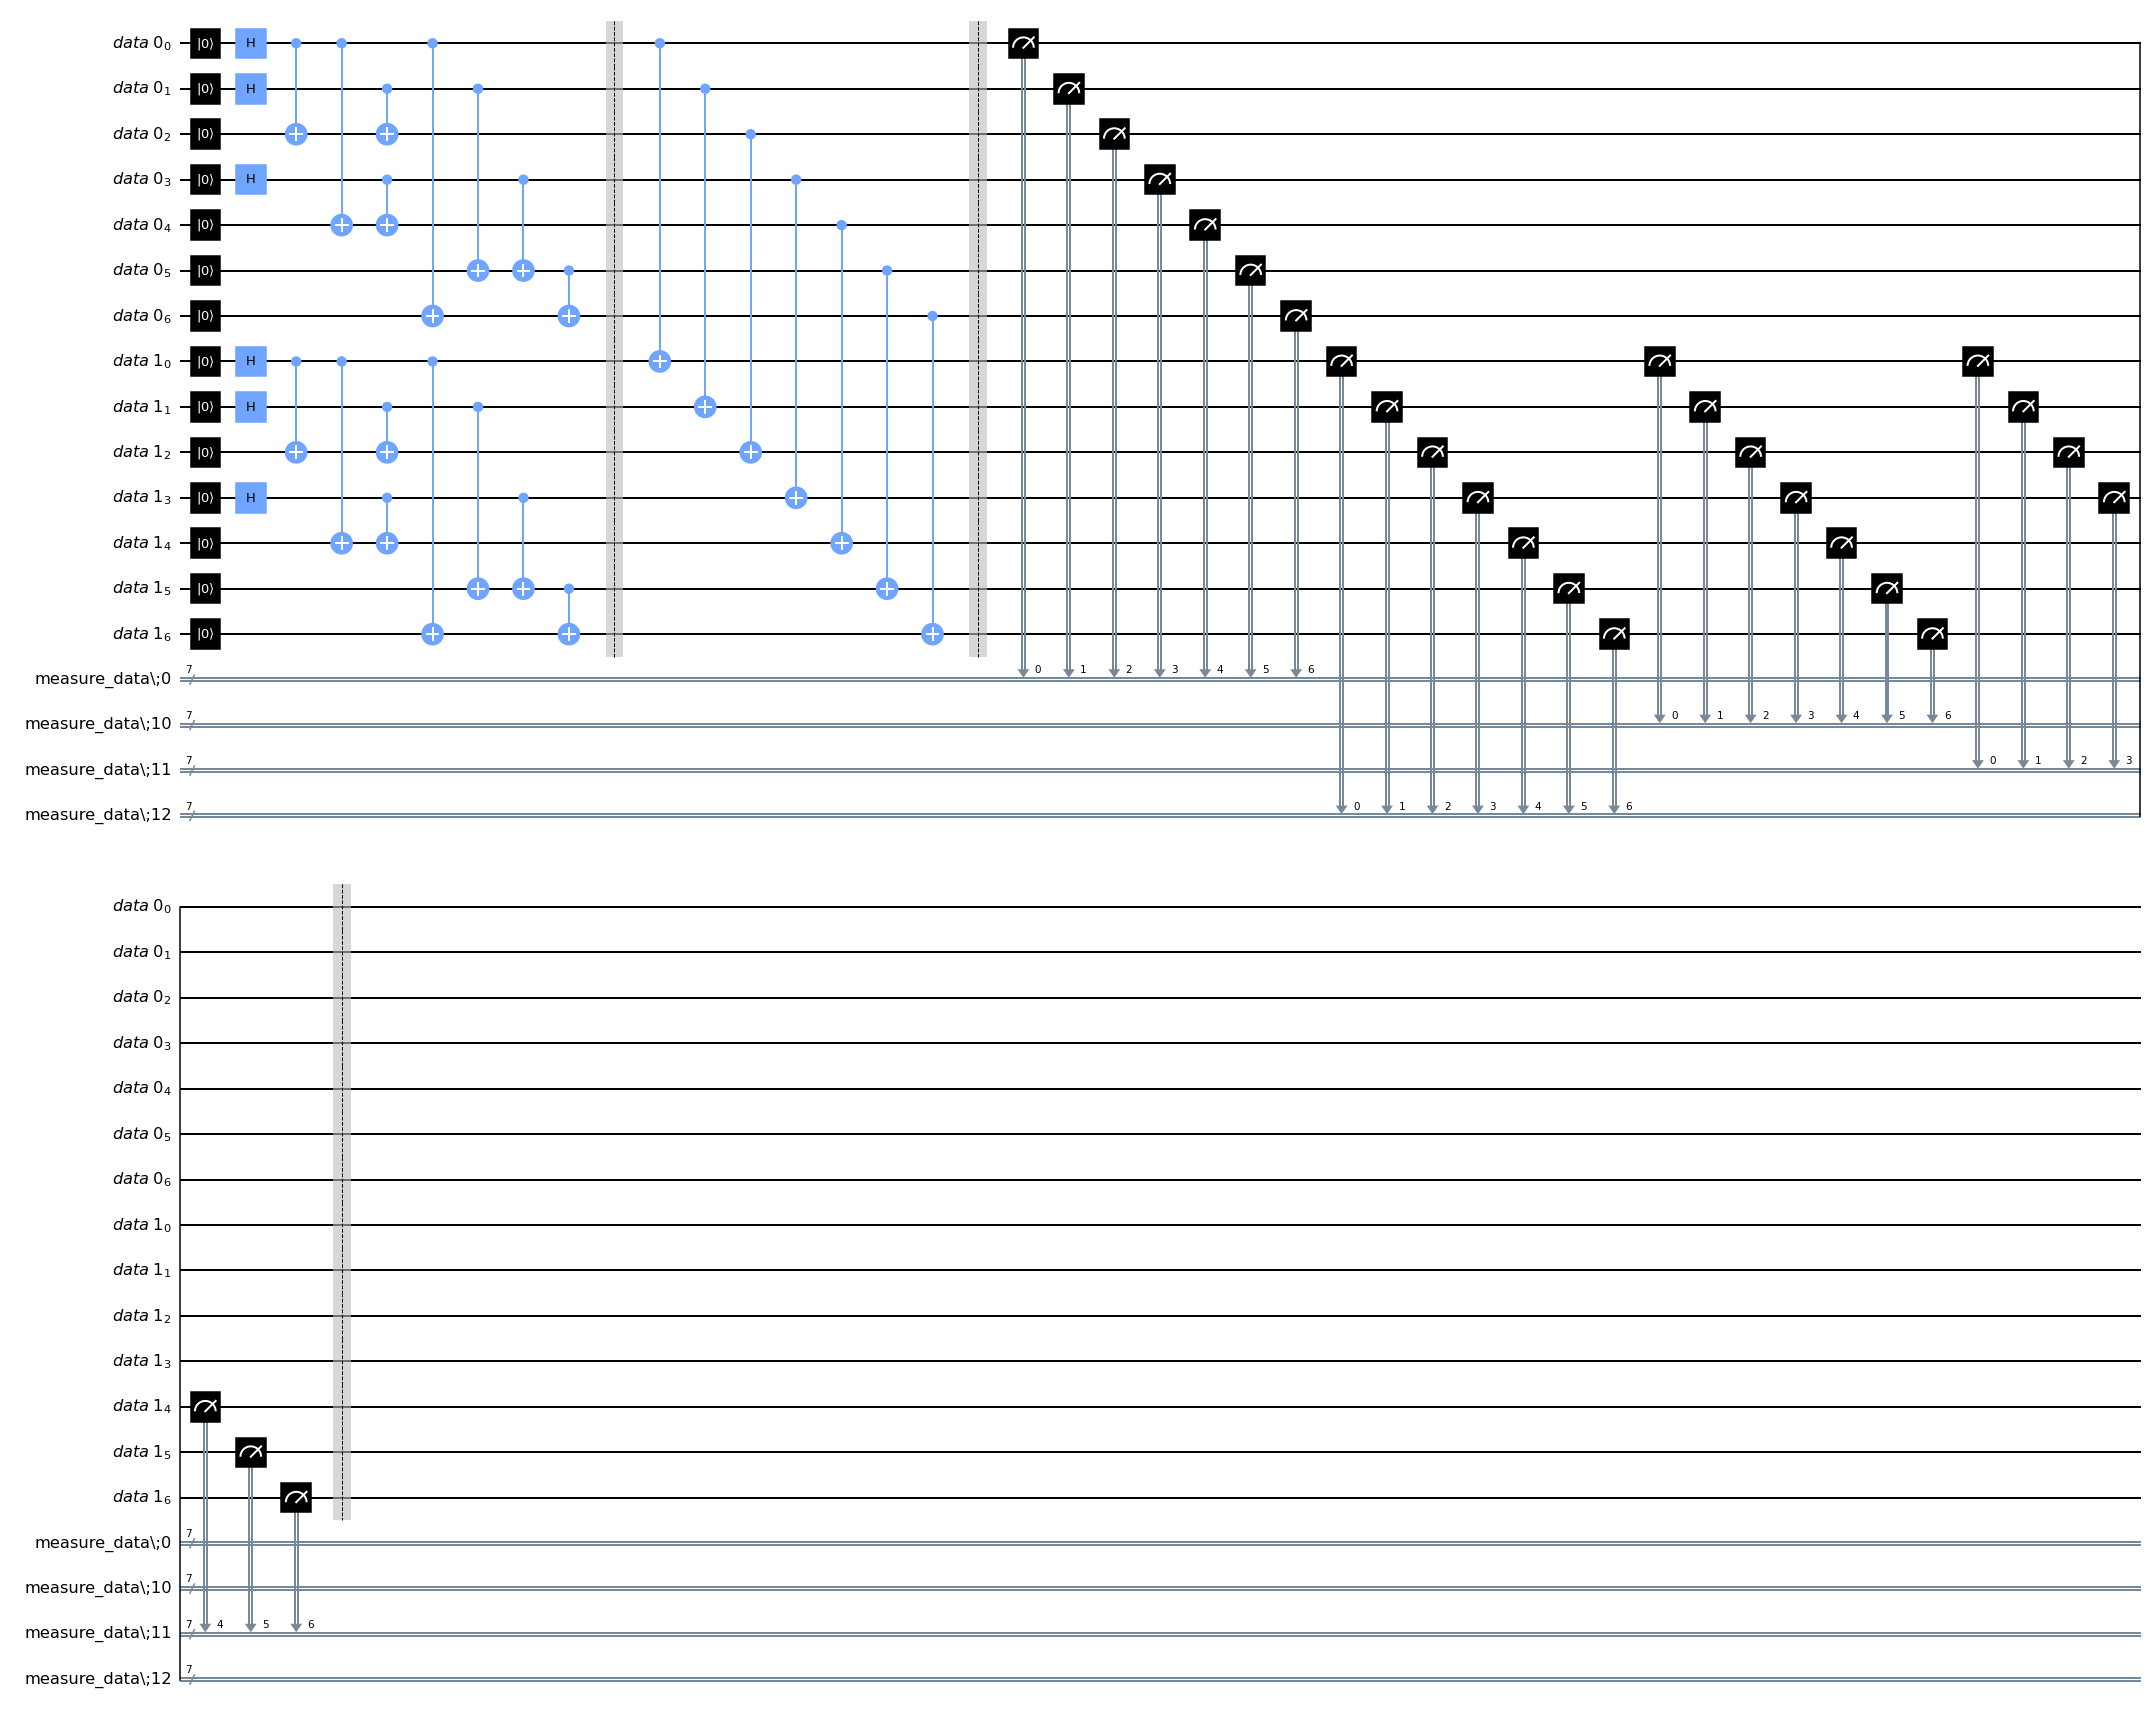

In [9]:
qubit.draw(output='mpl', filename = 'Steane_code_circuit.jpg', fold = 43)